In [10]:
import os
import math
import requests
import pandas as pd
import geopandas as gpd
from arcgis import GIS
import contextily as cx
import numpy as np

In [5]:
def pull_geotable_agol(base_url, client, reproject_to_analysis_crs=True):
    """Given the url of an ArcGIS Feature Service layer, pulls the full dataset from ArcGIS Online and return a geopandas GeoDataFrame.

    This function can be used to to pull small to large datasets from ArcGIS Online. In most cases there is a maximum query limit
    set for ArcGIS Feature Service layers which range between 1000 records and 2000 records. This function helps bypass this limit
    by first querying for the full list of object ids, then 'chunking' that list into chunks less than the maximum query limit.

    base_url should be the url of the arcgis feature service layer. For example, the feature service url will look like this:
    https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/DRAFT_TOC_Transit_Stations_Existing_June_2023_/FeatureServer

    Feature services can contain multiple layers. To specify a specific layer, append the layer number to the url. For example, the feature
    service layer url will look like this: https://services3.arcgis.com/i2dkYWmb4wHvYPda/arcgis/rest/services/DRAFT_TOC_Transit_Stations_Existing_June_2023_/FeatureServer/0

    For more information on feature service layers, see the ArcGIS REST API documentation:
    https://developers.arcgis.com/rest/services-reference/enterprise/layer-feature-service-.htm

    Author: Joshua Croff

    Args:
        base_url: arcgis REST Service url
        client: arcgis client object
        reproject_to_analysis_crs: boolean, if True, will reproject to analysis crs EPSG:26910. Set to true by default. If false, will return data in EPSG:4326.

    Returns:
       geopandas GeoDataFrame: A GeoDataFrame object is a pandas.DataFrame that has a column with geometry.
    """

    # get token from client
    token = client._con.token

    # get feature ids from arcgis api
    id_query = f"query?outFields=*&where=1%3D1&f=json&returnIdsOnly=true&token={token}"
    id_url = os.path.join(base_url, id_query)
    id_response = requests.get(id_url)
    id_json = id_response.json()

    # create list of object ids & chunk to 1000 with is the arcgis api maximum record limit
    id_list = id_json["objectIds"]
    list_len = len(id_list)
    out_list_len = 225
    chunks = math.ceil(list_len / out_list_len)
    print(f"Breaking feature service layer IDs into {chunks} chunks")

    id_chunk_list = [id_list[i : i + out_list_len] for i in range(0, len(id_list), out_list_len)]

    # loop over list of lists and pull data
    # bad_urls = [] # uncomment to track and debug bad urls
    results = []
    for list_item in id_chunk_list:
        obj_str = ",".join(str(x) for x in list_item)
        query = f"query?outFields=*&where=&objectIds={obj_str}&f=geojson&token={token}"
        url = os.path.join(base_url, query)
        response = requests.get(url)
        response.raise_for_status()
        json = response.json()
        results += json["features"]
    # return [results, bad_urls] # uncomment to track and debug bad urls

    gdf = gpd.GeoDataFrame.from_features(results).set_crs("EPSG:4326")

    if reproject_to_analysis_crs:
        gdf = gdf.to_crs("EPSG:26910")

    return gdf

In [6]:
gis = GIS(username="sdamerdji", password='WJYBm_WeFW6wUPr')

In [7]:
base_url = "https://services.arcgis.com/Zs2aNLFN00jrS4gG/ArcGIS/rest/services/June2025_ForPublicMap/FeatureServer/5"

In [8]:
rezone_sites = pull_geotable_agol(base_url=base_url, client=gis, reproject_to_analysis_crs=False)

Breaking feature service layer IDs into 410 chunks


In [12]:
np.mean(rezone_sites['Base'] == rezone_sites['gen_hght']).round(3)

0.915

In [13]:
np.mean(rezone_sites['Base'] <= rezone_sites['gen_hght']).round(3)

0.917

In [14]:
np.sum(rezone_sites['Base'] < rezone_sites['gen_hght'])

169

For ease, let's visualize where parcels are downzoned:

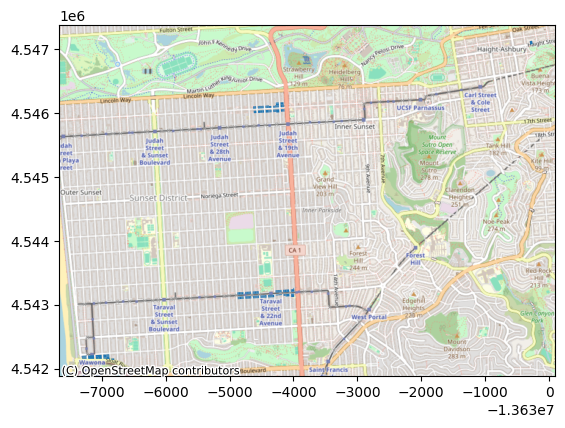

In [15]:
ax = rezone_sites[rezone_sites['Base'] < rezone_sites['gen_hght']].to_crs(epsg=3857).plot()
cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)

If we filter for parcels where base zoning height increases, the mean height increase is 13 feet and the median height increase is 10 feet.

In [16]:
rezone_sites.query('`Base` > `gen_hght`').assign(base_height_increase = lambda x: x.Base - x.gen_hght)['base_height_increase'].mean().round()

13.0

In [17]:
rezone_sites.query('`Base` > `gen_hght`').assign(base_height_increase = lambda x: x.Base - x.gen_hght)['base_height_increase'].median()

10.0

Let's sample some of the parcels that are downzoned so we can look into them.

In [50]:
rezone_sites[rezone_sites['Base'] < rezone_sites['gen_hght']].sample(random_state=123, n=5)

,geometry,OBJECTID,mapblklot,NEW_HEIGHT,NEW_HEIGHT_NUM,SplitHeight,Base,NewHeightBulk,height,gen_hght,CurrentZoning,ProposedZoning,SupervisorDistrict,LocalProgramHeight,Shape__Area,Shape__Length
34901,"POLYGON ((-122.48311 37.74311, -122.48301 37.7...",28606,2354038,85' Height Allowed,85.0,Not Split,50.0,50//85-R-4,65-A,65,NCD-TARAVAL,NCD-TARAVAL,4,85-R-4,2849.995117,256.999783
28092,"POLYGON ((-122.48362 37.74282, -122.48371 37.7...",74571,2355009,85' Height Allowed,85.0,Not Split,50.0,50//85-R-4,65-A,65,NCD-TARAVAL,NCD-TARAVAL,4,85-R-4,2500.000977,250.000092
78691,"POLYGON ((-122.47795 37.74275, -122.47837 37.7...",73255,2404001,85' Height Allowed,85.0,Not Split,50.0,50//85-R-4,65-A,65,NCD-TARAVAL,NCD-TARAVAL,4,85-R-4,4008.325195,307.357268
27306,"POLYGON ((-122.4793 37.74251, -122.47932 37.74...",27240,2403039,85' Height Allowed,85.0,Not Split,50.0,50//85-R-4,65-A,65,NCD-TARAVAL,NCD-TARAVAL,4,85-R-4,2500.003906,249.999958
81528,"POLYGON ((-122.48067 37.7633, -122.48046 37.76...",18524,1777001,85' Height Allowed,85.0,Not Split,50.0,50//85-R-4,65-A,65,NCD-IRVING,NCD-IRVING,4,85-R-4,6000.021484,320.000612
